Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [1]:
FN = 'vocabulary-embedding'

In [2]:
seed=42

In [3]:
vocab_size = 40000

In [4]:
embedding_dim = 100

In [6]:
lower = False # dont lower case the text

# read tokenized headlines and descriptions

In [7]:
import cPickle as pickle
FN0 = 'tokens' # this is the name of the data file which I assume you already have
with open('data-es/tn/sports50k-telam.pkl', 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [9]:
if lower:
    heads = [h.lower() for h in heads]

In [10]:
if lower:
    desc = [h.lower() for h in desc]

In [11]:
i=0
heads[i]

'Instituto, con un cambio, para visitar el lunes a Independiente Rivadavia\n'

In [12]:
desc[i]

'El defensor uruguayo Sergio Rodr\xc3\xadguez no se recuper\xc3\xb3 de un cuadro de gastroenteritis y no estar\xc3\xa1 en el equipo de Instituto de C\xc3\xb3rdoba que visitar\xc3\xa1 el lunes a las 21.30 a Independiente Rivadavia Mendoza por la quinta fecha del Torneo de Primera B Nacional, dej\xc3\xa1ndole su lugar en la zaga central a Facundo Ag\xc3\xbcero.'

In [13]:
keywords[i]

''

In [14]:
len(heads),len(set(heads))

(49998, 47189)

In [15]:
len(desc),len(set(desc))

(49998, 49057)

# build vocabulary

In [16]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [17]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [18]:
print vocab[:50]
print '...',len(vocab)

['de', 'la', 'en', 'el', 'a', 'del', 'y', 'que', 'por', 'con', 'El', 'los', 'se', 'al', 'un', 'hoy', 'para', 'su', 'fecha', 'ante', 'Primera', 'las', 'argentino', 'una', 'partido', 'Copa', 'San', 'como', 'La', 'ma\xc3\xb1ana', 'torneo', 'final', 'esta', 'equipo', 'f\xc3\xbatbol', 'Liga', 'Nacional', 'no', 'B', 'le', 'seleccionado', 'Boca', 'tras', 'Argentina', 'primera', 'sobre', 'River', 'Los', 'dos', 'lo']
... 75657


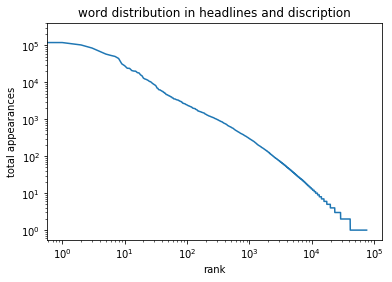

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, and so on.

# Index words

In [21]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [29]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.iteritems())

    return word2idx, idx2word

In [30]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [36]:
# Get glove number of symbols
glove_name = "data-es/glove/SBW-vectors-100-1MM.txt"
import commands
cmd_result =commands.getstatusoutput('wc -l '+glove_name)
glove_n_symbols = int(cmd_result[1].split()[0])
glove_n_symbols

1000653

In [41]:
#   get glove word2vec into an array
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = map(float,l[1:])
        i += 1
glove_embedding_weights *= globale_scale

In [27]:
glove_embedding_weights.std()

0.040815727600190289

In [ ]:
for w,i in glove_index_dict.iteritems():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [43]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print 'random-embedding/glove scale', scale, 'std', embedding.std()

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print 'number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size)

random-embedding/glove scale 0.00956354285866652 std 0.005521256656101686
number of tokens, in small vocab, found in glove and copied to embedding 21788 0.5447


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [44]:
glove_thr = 0.5

In [45]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [46]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.iteritems():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print '# of glove substitutes found', len(glove_match)

# of glove substitutes found 9442


manually check that the worst substitutions we are going to do are good enough

In [47]:
for orig, sub, score in glove_match[-10:]:
    print score, orig,'=>', idx2word[sub]

0.5009126470244796 cuervos => CALANDRIA
0.5008413593481128 recurrencia => tumor
0.5008288014698516 Carbonero => Kiko
0.5007494593684143 entubado => dique
0.5006904559456788 Aries => aparente
0.5003991718893522 protocolo => segura
0.5000843245354017 babel => fantástica
0.500050047502019 Antiguos => antiguos
0.5000436395201061 almanaques => Editorial
0.5000297363619396 anotada => lanzador


build a lookup table of index of outside words to index of inside words

In [48]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [49]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

49998

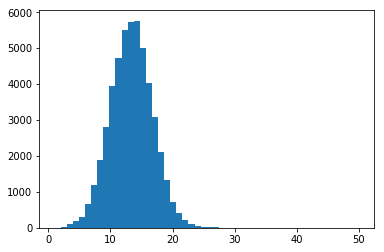

In [57]:
plt.hist(map(len,Y),bins=50);

In [51]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

49998

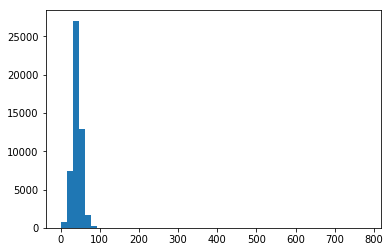

In [52]:
plt.hist(map(len,X),bins=50);

In [54]:
import cPickle as pickle
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [4]:
import cPickle as pickle
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)